In [1]:
import os
import time
import librosa
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchaudio
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
from abc import ABC, abstractmethod
from typing import Dict, List
from transformers import BertTokenizer
from transformers import Wav2Vec2Processor, Wav2Vec2Model

2025-05-11 09:00:13.645460: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746954013.944735      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746954014.026325      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
class AudioProcessor:
    SAMPLE_RATE = 16_000
    N_MELS = 64
    WINDOW_SIZE = 0.02  # 20 ms
    HOP_LENGTH = 0.01  # 10 ms
    N_FFT = 512
    EPSILON = 1e-6
    MIN_FREQUENCY = 85
    MAX_FREQUENCY = 3000

    # wiener filter parameters
    WIENER_N_FFT = 512
    WIENER_HOP_LENGTH = 128
    WIENER_WIN_LENGTH = 512
    NOISE_FRAME_COUNT = 5  # first 5 frames for noise estimation

    mel_spectrogram_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_fft=N_FFT,
        win_length=int(WINDOW_SIZE * SAMPLE_RATE),
        hop_length=int(HOP_LENGTH * SAMPLE_RATE),
        n_mels=N_MELS,
        center=True,
        power=2.0,
        f_min=MIN_FREQUENCY,
        f_max=MAX_FREQUENCY,
    )
    log_transform = torchaudio.transforms.AmplitudeToDB(stype="power", top_db=80)

    @staticmethod
    def wiener_filter(waveform: torch.Tensor) -> torch.Tensor:
        """Applies Wiener filtering for noise reduction.

        Parameters
        ----------
            waveform: Input audio tensor (1, T)
        Returns
        -------
            Denoised waveform (1, T)
        """
        stft = torch.stft(
            waveform.squeeze(0),
            n_fft=AudioProcessor.WIENER_N_FFT,
            hop_length=AudioProcessor.WIENER_HOP_LENGTH,
            win_length=AudioProcessor.WIENER_WIN_LENGTH,
            window=torch.hann_window(AudioProcessor.WIENER_WIN_LENGTH).to(waveform.device),
            return_complex=True,
        )

        # estimate noise from first few frames
        magnitude = torch.abs(stft)
        noise_estimate = magnitude[:, : AudioProcessor.NOISE_FRAME_COUNT].mean(dim=1, keepdim=True)

        # wiener gain
        gain = (magnitude - noise_estimate).clamp(min=0) / (magnitude + AudioProcessor.EPSILON)

        # reconstruct waveform
        enhanced_stft = stft * gain
        enhanced_waveform = torch.istft(
            enhanced_stft,
            n_fft=AudioProcessor.WIENER_N_FFT,
            hop_length=AudioProcessor.WIENER_HOP_LENGTH,
            win_length=AudioProcessor.WIENER_WIN_LENGTH,
            window=torch.hann_window(AudioProcessor.WIENER_WIN_LENGTH).to(waveform.device),
        )

        return enhanced_waveform.unsqueeze(0)

    @staticmethod
    def preprocess(waveform: torch.Tensor, original_sample_rate: int, apply_wiener: bool = True) -> torch.Tensor:
        """Preprocess the input audio waveform for feature extraction.

        This method performs the following steps:
        1. Converts stereo waveform to mono by averaging across channels.
        2. Normalizes the waveform to the range [-1, 1].
        3. Resamples the audio waveform to a target sample rate (16 kHz) if needed.
        4. Applies a Wiener filter to the waveform, if specified.
        5. Computes a log-Mel spectrogram of the waveform.

        Parameters
        ----------
        waveform : torch.Tensor
            A 1D or 2D tensor representing the audio waveform. Shape: (channels, samples).

        original_sample_rate : int
            The original sample rate of the waveform.

        apply_wiener : bool, optional, default=True
            Whether to apply the Wiener filter to the waveform. If set to False, the Wiener filter is skipped.

        Returns
        -------
        torch.Tensor
            A tensor representing the log-Mel spectrogram of the input waveform. Shape: (n_mel_bins, time_steps).
        """

        # convert to mono
        if waveform.size(0) > 1:
            waveform = waveform.mean(dim=0, keepdim=True)

        # normalize waveform to [-1, 1]
        waveform = waveform / waveform.abs().max()

        # resample to 16kHz if needed
        if original_sample_rate != AudioProcessor.SAMPLE_RATE:
            resampler = torchaudio.transforms.Resample(
                orig_freq=original_sample_rate, new_freq=AudioProcessor.SAMPLE_RATE
            )
            waveform = resampler(waveform)

        if apply_wiener:
            waveform = AudioProcessor.wiener_filter(waveform)

        # compute log-mel spectrogram
        mel_spec = AudioProcessor.mel_spectrogram_transform(waveform)
        log_mel_spec = AudioProcessor.log_transform(mel_spec + AudioProcessor.EPSILON)  # add epsilon to avoid log(0)

        # normalize
        mean = log_mel_spec.mean(dim=(1, 2), keepdim=True)
        std = log_mel_spec.std(dim=(1, 2), keepdim=True)
        log_mel_spec = (log_mel_spec - mean) / (std + 1e-5)

        return log_mel_spec


class TextProcessor(ABC):
    """Abstract base class for text processing to generate embeddings."""

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    @abstractmethod
    def process(self, text: str) -> torch.Tensor:
        """Process the input text and return its embedding.

        Parameters
        ----------
        text : str
            The input text to process.

        Returns
        -------
        torch.Tensor
            A tensor representing the processed text embedding.
        """
        pass


class BertProcessor(TextProcessor):
    """BERT-based implementation of the TextProcessor.

    This class uses a pre-trained BERT model to tokenize input text.

    Parameters
    ----------
    tokenizer : str, optional
        The name of the BERT tokenizer to use (default is "bert-base-uncased").
    """

    def __init__(self, tokenizer: str = "bert-base-uncased"):
        self.tokenizer = BertTokenizer.from_pretrained(tokenizer)

    def tokenize_text(self, text: str) -> torch.Tensor:
        """Tokenize input text using the BERT tokenizer.

        Parameters
        ----------
        text : str
            The input string to tokenize.

        Returns
        -------
        Dict[str, torch.Tensor]
            A dictionary containing input IDs, attention masks, and token type IDs.
        """
        return self.tokenizer(text, return_tensors="pt")["input_ids"].squeeze(0).to(BertProcessor.device)

    def process(self, text: str) -> torch.Tensor:
        """Process the input text by tokenizing and generating BERT embeddings.

        Parameters
        ----------
        text : str
            The input text to process.

        Returns
        -------
        torch.Tensor
            A tensor of token ids for the input text. The token ids maximum values is 30.522.
        """
        token_ids = self.tokenize_text(text)

        return token_ids

    def __len__(self):
        """Get the size of the tokenizer vocabulary.

        Returns
        -------
        int
            The number of tokens in the vocabulary.
        """
        return self.tokenizer.total_vocab_size


class Wav2Vec2TextProcessor(TextProcessor):
    """Wav2Vec2-based processor that extracts token ids from text.

    Parameters
    ----------
    model_name : str, optional
        The pretrained Wav2Vec2 processor to use (default is "facebook/wav2vec2-base-960h").
    """

    def __init__(self, model_name: str = "facebook/wav2vec2-base-960h"):
        self.processor = Wav2Vec2Processor.from_pretrained(model_name)
        self.vocab_dict = self.processor.tokenizer.get_vocab()
        self.char_to_id = {k: v for k, v in self.vocab_dict.items()}
        self.id_to_char = {v: k for k, v in self.vocab_dict.items()}

    def process(self, text: str) -> torch.Tensor:
        """Character based tokenizer

        Parameters
        ----------
        text : str
            The input text to tokenize.

        Returns
        -------
        torch.Tensor
            A tensor of token ids. The token ids maximum values is 32.
        """
        # replace spaces/newlines with the vocab word boundary character
        text = text.upper().replace(" ", "|").replace("\n", "|")
        token_ids = [self.char_to_id.get(char, self.char_to_id["<unk>"]) for char in text]
        return torch.tensor(token_ids)

    def decode_ids_to_tokens(self, token_ids: torch.Tensor) -> List[str]:
        """Convert token IDs back to their corresponding character tokens.

        Parameters
        ----------
        token_ids : torch.Tensor
            A tensor of token IDs.

        Returns
        -------
        List[str]
            A list of character tokens corresponding to the input token IDs.
        """
        return [self.id_to_char.get(token_id.item(), "<unk>") for token_id in token_ids]

    def __len__(self):
        """Get the size of the tokenizer vocabulary.

        Returns
        -------
        int
            The number of tokens in the vocabulary.
        """
        return len(self.vocab_dict)

In [3]:
class LibriSpeechDataset(Dataset):
    def __init__(
        self,
        data_path: str,
        max_spectrogram_length: int = 3200,
        max_label_length: int = 256,
        sample_rate: int = 16000,
        text_processor: TextProcessor = Wav2Vec2TextProcessor(),
    ):
        """
        Initializes the LibriSpeechDataset.

        Parameters
        ----------
        data_path : str
            Path to the directory containing audio files and transcriptions.
        max_spectrogram_length : int, optional
            Maximum time steps in the spectrogram (truncate/pad). Default is 3200.
        max_label_length : int, optional
            Maximum characters in the label (truncate/pad). Default is 256.
        sample_rate : int, optional
            Expected sample rate of audio files (resamples if needed). Default is 16000.
        text_processor : TextProcessor, optional
            A processor for handling text. Default is Wav2Vec2TokenizerProcessor.
        """
        self.data_path = data_path
        self.max_spectrogram_length = max_spectrogram_length
        self.max_label_length = max_label_length
        self.sample_rate = sample_rate
        self.samples = self._load_samples()
        self._validate_samples()
        self.text_processor = text_processor

    def _load_samples(self) -> List[str]:
        """
        Loads all .flac files from the specified data directory.

        Returns
        -------
        List[str]
            A list of paths to .flac files.
        """
        samples = []
        for root, _, files in os.walk(self.data_path):
            for file in files:
                if file.endswith(".flac"):
                    samples.append(os.path.join(root, file))
        if not samples:
            raise ValueError(f"No .flac files found in {self.data_path}")
        return samples

    def _validate_samples(self):
        """
        Validates that all audio files have corresponding transcription files.

        Raises
        ------
        FileNotFoundError
            If an audio file or its transcription is missing.
        """
        for audio_path in self.samples:
            if not os.path.exists(audio_path):
                raise FileNotFoundError(f"Audio file not found: {audio_path}")
            
            transcription_path = self._get_transcription_path(audio_path)
            if not os.path.exists(transcription_path):
                raise FileNotFoundError(
                    f"Transcription file not found for {audio_path}. "
                    f"Expected at: {transcription_path}"
                )

    def _get_transcription_path(self, audio_path: str) -> str:
        """
        Determines the path to the transcription file for a given audio file.

        Parameters
        ----------
        audio_path : str
            Path to the audio file.

        Returns
        -------
        str
            Path to the corresponding transcription file.

        Raises
        ------
        ValueError
            If the audio file name format is invalid.
        """
        file_name = os.path.basename(audio_path)
        file_id = file_name.replace(".flac", "")
        parts = file_id.split('-')
        if len(parts) < 2:
            raise ValueError(f"Invalid audio file name format: {file_name}")
        
        trans_file = f"{parts[0]}-{parts[1]}.trans.txt"
        return os.path.join(os.path.dirname(audio_path), trans_file)

    def __len__(self) -> int:
        """
        Returns the number of samples in the dataset.

        Returns
        -------
        int
            Number of samples.
        """
        return len(self.samples)

    def __getitem__(self, idx: int):
        """
        Retrieves a dataset item by index.

        Parameters
        ----------
        idx : int
            Index of the item.

        Returns
        -------
        Tuple
            A tuple containing preprocessed features, label text, and text embeddings.
        """
        audio_path = self.samples[idx]
        waveform, sample_rate = torchaudio.load(audio_path)
        features = AudioProcessor.preprocess(waveform, sample_rate)
        label = self._get_label(audio_path)
        text_embedding = self.text_processor.process(label)
        return features, label, text_embedding

    def _get_label(self, audio_path: str) -> str:
        """
        Loads and retrieves the transcription for an audio file.

        Parameters
        ----------
        audio_path : str
            Path to the audio file.

        Returns
        -------
        str
            The transcription text.

        Raises
        ------
        ValueError
            If the transcription is not found in the file.
        """
        transcription_path = self._get_transcription_path(audio_path)
        file_id = os.path.basename(audio_path).replace(".flac", "")
        with open(transcription_path, 'r') as f:
            for line in f:
                if line.startswith(file_id):
                    transcription = line[len(file_id):].strip()
                    break
            else:
                raise ValueError(
                    f"Transcription not found for {file_id} in {transcription_path}"
                )
        return transcription

    @staticmethod
    def collate_fn(batch):
        """
        Custom collate function to pad sequences in a batch.

        Parameters
        ----------
        batch : List[Tuple]
            A list of tuples, each containing features, label text, and text embeddings.

        Returns
        -------
        Tuple
            A tuple containing padded features, label texts, padded token IDs, and token lengths.
        """
        features, subtitles, token_ids = zip(*batch)
        max_feature_len = max(f.shape[2] for f in features)
        padded_features = torch.stack([
            F.pad(f, (0, max_feature_len - f.shape[2]))
            for f in features
        ])
        max_token_len = max(len(ids) for ids in token_ids)
        padded_token_ids = torch.zeros(len(token_ids), max_token_len, dtype=torch.long)
        token_lengths = torch.tensor([len(ids) for ids in token_ids], dtype=torch.long)
        for i, ids in enumerate(token_ids):
            padded_token_ids[i, :len(ids)] = torch.tensor(ids, dtype=torch.long)
        return padded_features, subtitles, padded_token_ids, token_lengths


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

In [4]:
class DeepSpeech2(nn.Module):
    def __init__(self, num_classes=29):
        """
        Initializes the DeepSpeech2 model.

        Parameters
        ----------
        num_classes : int, optional
            Number of output classes for the final layer. Default is 29.
        """
        super(DeepSpeech2, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, (11, 41), stride=(2, 2), padding=(5, 20)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(32, 32, (11, 21), stride=(1, 2), padding=(5, 10)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(32, 64, (11, 21), stride=(1, 2), padding=(5, 10)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
        )
        self.rnn = nn.LSTM(
            input_size=64,
            hidden_size=512,
            num_layers=5,
            bidirectional=True,
            batch_first=True,
            dropout=0.3,
        )
        self.fc = nn.Linear(512 * 2, num_classes)

    def forward(self, x):
        """
        Defines the forward pass of the DeepSpeech2 model.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor with shape [batch, 1, freq, time].

        Returns
        -------
        torch.Tensor
            Output tensor with shape [batch, time, num_classes].
        """
        x = self.conv_layers(x)
        x = x.permute(0, 3, 1, 2)
        x = x.reshape(x.size(0), x.size(1), -1)
        if x.size(-1) != 64:
            self.proj = nn.Linear(x.size(-1), 64).to(x.device)
            x = self.proj(x)
        x, _ = self.rnn(x)
        x = self.fc(x)
        return x


In [5]:
class FasterDeepSpeech2(nn.Module):
    def __init__(self, num_classes=32):
        """
        Initializes the FasterDeepSpeech2 model with reduced complexity for faster computation.

        Parameters
        ----------
        num_classes : int, optional
            Number of output classes for the final layer. Default is 32.
        """
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, (11, 21), stride=(2, 2), padding=(5, 10)),
            nn.ReLU(),
            nn.Conv2d(16, 32, (11, 11), stride=(1, 1), padding=(5, 5)),
            nn.ReLU()
        )
        self.rnn = nn.LSTM(
            input_size=32 * 101,
            hidden_size=128,
            num_layers=2,
            bidirectional=True,
            batch_first=True
        )
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        """
        Defines the forward pass of the FasterDeepSpeech2 model.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor with shape [batch, 1, freq, time].

        Returns
        -------
        torch.Tensor
            Output tensor with shape [batch, time, num_classes].
        """
        x = self.conv_layers(x)
        x = x.permute(0, 3, 1, 2)
        x = x.reshape(x.size(0), x.size(1), -1)
        if x.size(-1) != 3232:
            self.proj = nn.Linear(x.size(-1), 3232).to(x.device)
            x = self.proj(x)
        x, _ = self.rnn(x)
        x = self.fc(x)
        return x

In [6]:
def plot_loss(train_loss, val_loss, path: str | None = None, name: str | None = None):
    """Plot the training and validation loss over epochs.

    Parameters
    ----------
    train_loss : list
        List of training loss values for each epoch.
    val_loss : list
        List of validation loss values for each epoch.
    path: str | None
        Directory path where to save output. Default is None, meaning output will not be saved.
    name: str | None
        File name of the saved output.

    Returns
    -------
    None
        This function does not return any value. It directly displays the plot.
    """

    plt.title("Training & Validation Loss")
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Val Loss")

    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.legend()
    plt.grid(True)

    if path is not None:
        name = name if name is not None else "loss.png"
        plt.savefig(os.path.join(path, name))
    plt.show()

In [7]:
class ModelCheckpoint:
    def __init__(self, save_dir="checkpoints", monitor="val_loss", mode="min", verbose=True):
        """
        Args:
            save_dir (str): Path to save models.
            monitor (str): Metric to monitor ('val_loss').
            mode (str): 'min' means lower is better, 'max' means higher is better.
            verbose (bool): Whether to print messages.
        """
        self.save_dir = save_dir
        os.makedirs(self.save_dir, exist_ok=True)

        self.monitor = monitor
        self.mode = mode
        self.verbose = verbose

        if self.mode == "min":
            self.best_score = float("inf")
        else:
            self.best_score = -float("inf")

        self.best_model_data = None
        self.best_epoch = None

    def update(
        self,
        epoch,
        model,
        optimizer,
        scheduler,
        current_score,
    ):
        """
        Update internal best model state if current score is better.
        """

        is_best = False

        if (self.mode == "min" and current_score < self.best_score) or (
            self.mode == "max" and current_score > self.best_score
        ):
            self.best_score = current_score
            self.best_epoch = epoch
            is_best = True

        if is_best:
            self.best_model_data = {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                # "scheduler_state_dict": scheduler.state_dict(),
                self.monitor: current_score,
            }

            if self.verbose:
                print(f"[ModelCheckpoint] Updated best model at epoch {epoch} with {self.monitor}: {current_score:.4f}")

    def save(self, filename="model.pth"):
        """
        Save the best model data to disk.
        """

        if self.best_model_data is None:
            print("[ModelCheckpoint] No model to save yet.")
            return

        save_path = os.path.join(self.save_dir, filename)
        torch.save(self.best_model_data, save_path)

        if self.verbose:
            print(f"[ModelCheckpoint] Saved best model to '{save_path}' (epoch {self.best_epoch}).")

In [8]:
def train_and_validate(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device,
    epochs=10,
    save_path=None
):
    """
    Trains and validates the given model.

    Parameters
    ----------
    model : torch.nn.Module
        The model to be trained and validated.
    train_loader : torch.utils.data.DataLoader
        DataLoader for the training dataset.
    val_loader : torch.utils.data.DataLoader
        DataLoader for the validation dataset.
    optimizer : torch.optim.Optimizer
        Optimizer for updating the model parameters.
    criterion : torch.nn.Module
        Loss function used during training and validation.
    device : torch.device
        Device on which the model and data will be loaded.
    epochs : int, optional
        Number of epochs to train the model. Default is 10.
    save_path : str, optional
        Path to save the loss plot. Default is None.

    Returns
    -------
    torch.nn.Module
        The trained model.
    list
        List of training losses for each epoch.
    list
        List of validation losses for each epoch.
    """
    train_losses = []
    val_losses = []

    model_checkpoint = ModelCheckpoint()

    for epoch in range(epochs):
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        train_losses.append(train_loss)

        model.eval()
        val_loss = validate_epoch(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        model_checkpoint.update(epoch, model, optimizer, None, val_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    plot_loss(train_losses, val_losses, path=save_path, name="loss_curve.png")
    model_checkpoint.save(filename="deepspeech2.pth")

    return model, train_losses, val_losses


def train_epoch(model, dataloader, optimizer, criterion, device):
    """
    Performs a single training epoch.

    Parameters
    ----------
    model : torch.nn.Module
        The model to be trained.
    dataloader : torch.utils.data.DataLoader
        DataLoader for the training dataset.
    optimizer : torch.optim.Optimizer
        Optimizer for updating the model parameters.
    criterion : torch.nn.Module
        Loss function used during training.
    device : torch.device
        Device on which the model and data will be loaded.

    Returns
    -------
    float
        Average training loss for the epoch.
    """
    total_loss = 0.0

    for features, labels, token_ids, token_lengths in tqdm(dataloader, desc="Training"):
        features = features.to(device)
        token_ids = token_ids.to(device)
        token_lengths = token_lengths.to(device)

        if features.dim() == 5:
            features = features.squeeze(2)

        outputs = model(features)

        input_lengths = torch.full(
            size=(outputs.size(0),),
            fill_value=outputs.size(1),
            dtype=torch.long,
            device=outputs.device
        )

        loss = criterion(
            outputs.log_softmax(2).permute(1, 0, 2),
            token_ids,
            input_lengths,
            token_lengths
        )
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


def validate_epoch(model, dataloader, criterion, device):
    """
    Performs a single validation epoch.

    Parameters
    ----------
    model : torch.nn.Module
        The model to be validated.
    dataloader : torch.utils.data.DataLoader
        DataLoader for the validation dataset.
    criterion : torch.nn.Module
        Loss function used during validation.
    device : torch.device
        Device on which the model and data will be loaded.

    Returns
    -------
    float
        Average validation loss for the epoch.
    """
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for features, labels, token_ids, token_lengths in tqdm(dataloader, desc="Validating"):
            features = features.to(device)
            token_ids = token_ids.to(device)
            token_lengths = token_lengths.to(device)

            if features.dim() == 5:
                features = features.squeeze(2)

            outputs = model(features)

            input_lengths = torch.full(
                size=(outputs.size(0),),
                fill_value=outputs.size(1),
                dtype=torch.long,
                device=outputs.device
            )

            loss = criterion(
                outputs.log_softmax(2).permute(1, 0, 2),
                token_ids,
                input_lengths,
                token_lengths
            )
            total_loss += loss.item()

    return total_loss / len(dataloader)


def get_output_lengths(input_length):
    """
    Calculates the output length of a sequence after passing through the convolutional layers.

    Parameters
    ----------
    input_length : int
        Length of the input sequence.

    Returns
    -------
    int
        Length of the output sequence after convolutions.
    """
    for k, s, p in [(41, 2, 20), (21, 2, 10), (21, 2, 10)]:
        input_length = (input_length + 2 * p - k) // s + 1
    return input_length

In [9]:
# # Run Python garbage collector
# gc.collect()

# # Empty PyTorch's CUDA cache
# torch.cuda.empty_cache()

# # Optionally, clear CUDA memory from PyTorch's memory allocator
# torch.cuda.ipc_collect()

Training:   0%|          | 0/7135 [00:00<?, ?it/s]/tmp/ipykernel_19/3989701684.py:189: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_token_ids[i, :len(ids)] = torch.tensor(ids, dtype=torch.long)
Validating: 100%|██████████| 676/676 [01:42<00:00,  6.60it/s]


[ModelCheckpoint] Updated best model at epoch 0 with val_loss: 2.9246
Epoch 1/20 | Train Loss: 3.9261 | Val Loss: 2.9246


Validating: 100%|██████████| 676/676 [01:14<00:00,  9.11it/s]


[ModelCheckpoint] Updated best model at epoch 1 with val_loss: 2.8873
Epoch 2/20 | Train Loss: 2.8608 | Val Loss: 2.8873


Validating: 100%|██████████| 676/676 [01:14<00:00,  9.08it/s]


[ModelCheckpoint] Updated best model at epoch 2 with val_loss: 2.8759
Epoch 3/20 | Train Loss: 2.8504 | Val Loss: 2.8759


Validating: 100%|██████████| 676/676 [01:17<00:00,  8.71it/s]


[ModelCheckpoint] Updated best model at epoch 3 with val_loss: 2.8691
Epoch 4/20 | Train Loss: 2.8439 | Val Loss: 2.8691


Validating: 100%|██████████| 676/676 [01:13<00:00,  9.18it/s]


[ModelCheckpoint] Updated best model at epoch 4 with val_loss: 2.7558
Epoch 5/20 | Train Loss: 2.7687 | Val Loss: 2.7558


Validating: 100%|██████████| 676/676 [01:14<00:00,  9.03it/s]


[ModelCheckpoint] Updated best model at epoch 5 with val_loss: 2.7159
Epoch 6/20 | Train Loss: 2.6821 | Val Loss: 2.7159


Validating: 100%|██████████| 676/676 [01:16<00:00,  8.82it/s]


[ModelCheckpoint] Updated best model at epoch 6 with val_loss: 2.6765
Epoch 7/20 | Train Loss: 2.6461 | Val Loss: 2.6765


Validating: 100%|██████████| 676/676 [01:15<00:00,  8.95it/s]


[ModelCheckpoint] Updated best model at epoch 7 with val_loss: 2.6449
Epoch 8/20 | Train Loss: 2.6131 | Val Loss: 2.6449


Validating: 100%|██████████| 676/676 [01:16<00:00,  8.79it/s]


[ModelCheckpoint] Updated best model at epoch 8 with val_loss: 2.6196
Epoch 9/20 | Train Loss: 2.5845 | Val Loss: 2.6196


Validating: 100%|██████████| 676/676 [01:16<00:00,  8.83it/s]


[ModelCheckpoint] Updated best model at epoch 9 with val_loss: 2.5933
Epoch 10/20 | Train Loss: 2.5605 | Val Loss: 2.5933


Validating: 100%|██████████| 676/676 [01:17<00:00,  8.71it/s]


[ModelCheckpoint] Updated best model at epoch 10 with val_loss: 2.5733
Epoch 11/20 | Train Loss: 2.5369 | Val Loss: 2.5733


Validating: 100%|██████████| 676/676 [01:17<00:00,  8.75it/s]


[ModelCheckpoint] Updated best model at epoch 11 with val_loss: 2.5487
Epoch 12/20 | Train Loss: 2.5133 | Val Loss: 2.5487


Validating: 100%|██████████| 676/676 [01:18<00:00,  8.61it/s]


[ModelCheckpoint] Updated best model at epoch 12 with val_loss: 2.5306
Epoch 13/20 | Train Loss: 2.4929 | Val Loss: 2.5306


Validating: 100%|██████████| 676/676 [01:16<00:00,  8.89it/s]


[ModelCheckpoint] Updated best model at epoch 13 with val_loss: 2.5178
Epoch 14/20 | Train Loss: 2.4766 | Val Loss: 2.5178


Validating: 100%|██████████| 676/676 [01:17<00:00,  8.77it/s]


[ModelCheckpoint] Updated best model at epoch 14 with val_loss: 2.5061
Epoch 15/20 | Train Loss: 2.4636 | Val Loss: 2.5061


Validating: 100%|██████████| 676/676 [01:16<00:00,  8.85it/s]


[ModelCheckpoint] Updated best model at epoch 15 with val_loss: 2.4927
Epoch 16/20 | Train Loss: 2.4508 | Val Loss: 2.4927


Validating: 100%|██████████| 676/676 [01:16<00:00,  8.81it/s]


[ModelCheckpoint] Updated best model at epoch 16 with val_loss: 2.4838
Epoch 17/20 | Train Loss: 2.4400 | Val Loss: 2.4838


Validating: 100%|██████████| 676/676 [01:16<00:00,  8.82it/s]


[ModelCheckpoint] Updated best model at epoch 17 with val_loss: 2.4738
Epoch 18/20 | Train Loss: 2.4301 | Val Loss: 2.4738


Validating: 100%|██████████| 676/676 [01:15<00:00,  8.90it/s]


[ModelCheckpoint] Updated best model at epoch 18 with val_loss: 2.4666
Epoch 19/20 | Train Loss: 2.4212 | Val Loss: 2.4666


Validating: 100%|██████████| 676/676 [01:16<00:00,  8.82it/s]


[ModelCheckpoint] Updated best model at epoch 19 with val_loss: 2.4593
Epoch 20/20 | Train Loss: 2.4127 | Val Loss: 2.4593


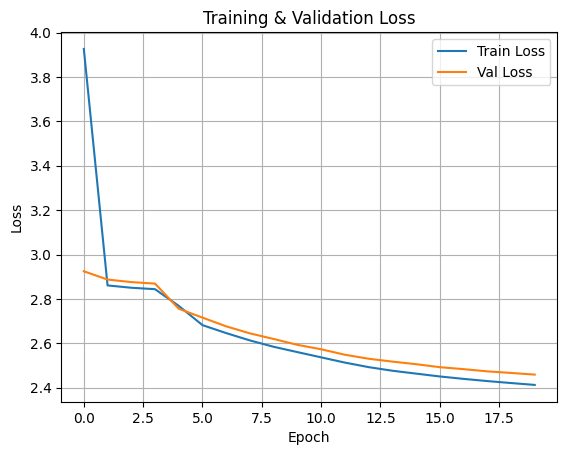

[ModelCheckpoint] Saved best model to 'checkpoints/deepspeech2.pth' (epoch 19).
Elapsed time: 7h 59m 16.17s


In [10]:
def main():
    # Dataset
    traindataset = LibriSpeechDataset(data_path="/kaggle/input/librispeech-clean/LibriSpeech/train-clean-100")
    traindataloader = DataLoader(traindataset, batch_size=4, shuffle=True, collate_fn=LibriSpeechDataset.collate_fn)

    validationdataset = LibriSpeechDataset(data_path="/kaggle/input/librispeech-clean/LibriSpeech/dev-clean")
    validationdataloader = DataLoader(validationdataset, batch_size=4, shuffle=False, collate_fn=LibriSpeechDataset.collate_fn)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FasterDeepSpeech2().to(device)

    criterion = nn.CTCLoss(blank=0, zero_infinity=True)
    optimizer = optim.Adam(model.parameters(), lr=1e-5)

    start = time.time()

    train_and_validate(model, traindataloader, validationdataloader, optimizer, criterion, device, epochs=20)

    end = time.time()

    elapsed_time = end - start
    
    hours, rem = divmod(elapsed_time, 3600)
    minutes, seconds = divmod(rem, 60)
    
    print(f"Elapsed time: {int(hours)}h {int(minutes)}m {seconds:.2f}s")

if __name__ == "__main__":
    main()